## Working with Exogenous Data

In [1]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sml
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import datetime
import shap
from pmdarima import auto_arima

/home/martinsawojide/miniforge3/envs/inflation_nowcasting/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# get detrended gt data
detrended_trends_df = pd.read_csv('./detrended_google_trends_data.csv')
display(detrended_trends_df)

,Month,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12
0,2011-01-01,58.0,984.2,-34.674853,12.265352,-38.543168,1813.0,-37.247719,27.393146,-26.353890,88.0,71.972304,53.0,12.209687
1,2011-02-01,56.0,953.6,-38.634425,60.135251,38.551132,1971.6,-38.928577,25.214203,32.212519,138.0,43.370200,53.0,6.516475
2,2011-03-01,58.0,965.6,15.189084,58.995884,-0.113440,2112.5,27.362487,12.089573,8.703165,133.0,15.639949,89.0,13.240377
3,2011-04-01,57.0,935.8,-22.201174,63.845241,15.459047,1846.8,-34.776741,23.018628,-15.881686,104.0,-25.325198,57.0,6.277186
4,2011-05-01,57.0,927.1,-10.802047,27.681307,66.264518,2029.8,-26.148478,6.000740,50.458231,119.0,-9.831991,53.0,-1.477304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,2024-11-01,55.0,716.4,150.990991,-708.490871,-498.038005,743.0,-118.844748,-108.091417,-148.082623,102.0,-684.072739,96.0,-273.809202
167,2024-12-01,53.0,718.3,155.187379,-881.323792,-563.679889,604.4,-125.233229,-90.862949,-233.455920,68.0,-779.178754,101.0,-297.274710
168,2025-01-01,61.0,763.2,165.690055,-671.400097,-530.756567,800.0,-123.817629,-126.684515,-140.860896,98.0,-746.933297,102.0,-302.121445
169,2025-02-01,59.0,699.4,197.502170,-750.221800,-579.272110,823.4,-131.600162,-97.556743,-126.297285,97.0,-737.443119,89.0,-314.053616


In [4]:
# inflation (2011 - Mar 2025)
inflation_data = pd.read_csv('./yoy_inflation_till_March_2025.csv')
inflation_data.head()

,Month,Year-on-Year Change (%)
0,Jan '11,12.079665
1,Feb '11,11.099837
2,Mar '11,12.779128
3,Apr '11,11.291282
4,May '11,12.352128


In [5]:
# Convert string to datetime and then format
def format_date(date_str):
    date_obj = datetime.datetime.strptime(date_str, '%Y-%m')
    return date_obj.strftime('%b \'%y')

In [6]:
inflation_data = inflation_data.rename(columns={'Year-on-Year Change (%)': 'Inflation rate'})
inflation_data['Month'] = pd.to_datetime(inflation_data['Month'], format='%b \'%y')
inflation_data.head()

,Month,Inflation rate
0,2011-01-01,12.079665
1,2011-02-01,11.099837
2,2011-03-01,12.779128
3,2011-04-01,11.291282
4,2011-05-01,12.352128


In [7]:
# # merge the two dataframes on the Month column
# merged_data = pd.merge(detrended_trends_df, inflation_data, on='Month', how='left')
# # display the first few rows of the merged DataFrame
# merged_data.tail()

# First, let's check the data types
print("detrended_trends_df Month dtype:", detrended_trends_df['Month'].dtype)
print("inflation_data Month dtype:", inflation_data['Month'].dtype)

# Convert both to datetime
detrended_trends_df['Month'] = pd.to_datetime(detrended_trends_df['Month'])
inflation_data['Month'] = pd.to_datetime(inflation_data['Month'])

# Now merge the dataframes
merged_data = pd.merge(detrended_trends_df, inflation_data, on='Month', how='left')

# Verify the merge worked
print("\nMerged data shape:", merged_data.shape)
merged_data.tail()

detrended_trends_df Month dtype: object
inflation_data Month dtype: datetime64[ns]

Merged data shape: (171, 15)


,Month,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,Inflation rate
166,2024-11-01,55.0,716.4,150.990991,-708.490871,-498.038005,743.0,-118.844748,-108.091417,-148.082623,102.0,-684.072739,96.0,-273.809202,34.598334
167,2024-12-01,53.0,718.3,155.187379,-881.323792,-563.679889,604.4,-125.233229,-90.862949,-233.455920,68.0,-779.178754,101.0,-297.274710,34.796057
168,2025-01-01,61.0,763.2,165.690055,-671.400097,-530.756567,800.0,-123.817629,-126.684515,-140.860896,98.0,-746.933297,102.0,-302.121445,28.871419
169,2025-02-01,59.0,699.4,197.502170,-750.221800,-579.272110,823.4,-131.600162,-97.556743,-126.297285,97.0,-737.443119,89.0,-314.053616,27.941947
170,2025-03-01,134.0,743.1,216.626875,-780.590913,-586.230590,745.5,-121.583045,-104.480263,-164.764823,90.0,-783.614968,95.0,-324.475429,27.018329


In [8]:
# get train and test temporal split

# TRAIN: Jan 2011 - Mar 2017; TEST: Apr 2017 - Mar 2025

# split_date = '2018-07-01'
split_date = '2017-04-01'

# Create train-test split
train_data = merged_data[merged_data['Month'] < split_date]
test_data = merged_data[merged_data['Month'] >= split_date]

# Get features (X) and target (y)
target_col = 'Inflation rate'
feature_cols = [col for col in merged_data.columns if col not in ['Month', target_col]]

X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

# Print shapes to verify split
print("Training set shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print("\nTest set shapes:")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# Display split point information
print("\nTrain period:", train_data['Month'].min().strftime('%Y-%m'), "to", train_data['Month'].max().strftime('%Y-%m'))
print("Test period:", test_data['Month'].min().strftime('%Y-%m'), "to", test_data['Month'].max().strftime('%Y-%m'))

Training set shapes:
X_train: (75, 13)
y_train: (75,)

Test set shapes:
X_test: (96, 13)
y_test: (96,)

Train period: 2011-01 to 2017-03
Test period: 2017-04 to 2025-03


In [9]:
def normalize_features(X_train, X_test, feature_range=(0, 100)):
    """
    Normalize each feature independently to a specified range using min-max scaling.
    Returns normalized training data, test data, and scaling parameters.
    """
    X_train_normalized = pd.DataFrame(index=X_train.index, columns=X_train.columns)
    X_test_normalized = pd.DataFrame(index=X_test.index, columns=X_test.columns)
    
    # Store scaling parameters for each column
    scaling_params = {}
    
    # Process each column independently
    for column in X_train.columns:
        # Get min and max for the column from training data
        min_val = X_train[column].min()
        max_val = X_train[column].max()
        
        # Store scaling parameters
        scaling_params[column] = {'min': min_val, 'max': max_val}
        
        # Apply min-max scaling to train data
        X_train_normalized[column] = (X_train[column] - min_val) * (feature_range[1] - feature_range[0]) / (max_val - min_val) + feature_range[0]
        
        # Apply same transformation to test data using training parameters
        X_test_normalized[column] = (X_test[column] - min_val) * (feature_range[1] - feature_range[0]) / (max_val - min_val) + feature_range[0]
    
    # Verify scaling for each column
    print("\nScaling verification (sample of 12 columns):")
    for column in list(X_train.columns)[:13]:
        print(f"\nColumn: {column}")
        print(f"Train - Min: {X_train_normalized[column].min():.2f}, Max: {X_train_normalized[column].max():.2f}")
        print(f"Test  - Min: {X_test_normalized[column].min():.2f}, Max: {X_test_normalized[column].max():.2f}")
    
    return X_train_normalized, X_test_normalized, scaling_params

# Apply normalization
X_train_norm, X_test_norm, scaling_params = normalize_features(X_train, X_test)
print(scaling_params)

# Update the training and test data
X_train = X_train_norm
X_test = X_test_norm

# # Validation checks
# for column in X_train.columns:
#     assert 0 <= X_train[column].min() <= X_train[column].max() <= 100, f"Column {column} not properly scaled"


Scaling verification (sample of 12 columns):

Column: cluster_0
Train - Min: 0.00, Max: 100.00
Test  - Min: -0.42, Max: 45.00

Column: cluster_1
Train - Min: 0.00, Max: 100.00
Test  - Min: 1.90, Max: 75.37

Column: cluster_2
Train - Min: 0.00, Max: 100.00
Test  - Min: 6.65, Max: 223.04

Column: cluster_3
Train - Min: 0.00, Max: 100.00
Test  - Min: -241.60, Max: 171.83

Column: cluster_4
Train - Min: 0.00, Max: 100.00
Test  - Min: -221.23, Max: 115.71

Column: cluster_5
Train - Min: 0.00, Max: 100.00
Test  - Min: -5.66, Max: 25.88

Column: cluster_6
Train - Min: 0.00, Max: 100.00
Test  - Min: -49.70, Max: 39.49

Column: cluster_7
Train - Min: 0.00, Max: 100.00
Test  - Min: -12.61, Max: 95.15

Column: cluster_8
Train - Min: 0.00, Max: 100.00
Test  - Min: -40.42, Max: 112.14

Column: cluster_9
Train - Min: 0.00, Max: 100.00
Test  - Min: 5.04, Max: 138.13

Column: cluster_10
Train - Min: 0.00, Max: 100.00
Test  - Min: -126.97, Max: 94.13

Column: cluster_11
Train - Min: 0.00, Max: 100.00


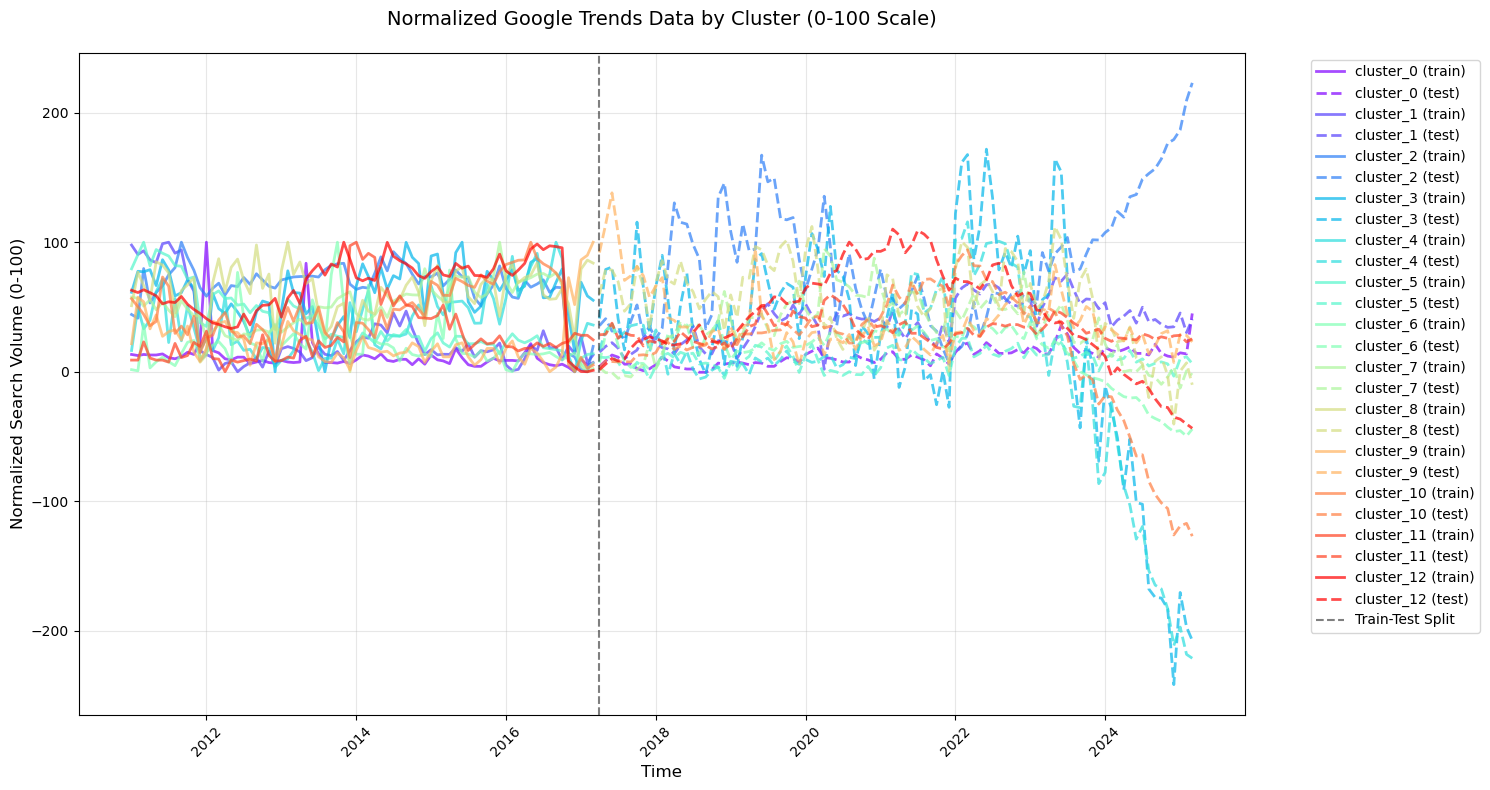

In [30]:
# Create figure for normalized cluster values
plt.figure(figsize=(15, 8))

# Get cluster columns (they are all the columns in X_train/X_test)
cluster_cols = X_train.columns

# Create colormap for different clusters
colors = plt.cm.rainbow(np.linspace(0, 1, len(cluster_cols)))

# Plot training data
for col, color in zip(cluster_cols, colors):
    plt.plot(train_data['Month'], 
             X_train[col],
             label=f"{col} (train)",
             alpha=0.7,
             linewidth=2,
             color=color)
    
    # Plot test data with same color but different style
    plt.plot(test_data['Month'], 
             X_test[col],
             label=f"{col} (test)",
             alpha=0.7,
             linewidth=2,
             color=color,
             linestyle='--')

# Add vertical line to separate train and test sets
split_date = pd.to_datetime('2017-04-01')
plt.axvline(x=split_date, color='black', linestyle='--', 
            label='Train-Test Split', alpha=0.5)

# Customize the plot
plt.title('Normalized Google Trends Data by Cluster (0-100 Scale)', fontsize=14, pad=20)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Normalized Search Volume (0-100)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig("normalized_gt_data.png")

plt.show()

In [11]:
# calculate eval metrics
def calculate_metrics(y_true, y_pred):

    # Convert inputs to numpy arrays
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # from sklearn.utils.validation import check_array
    # # Convert inputs to numpy arrays with new parameter name
    # y_true = check_array(y_true.reshape(-1, 1), ensure_all_finite=True).flatten()
    # y_pred = check_array(y_pred.reshape(-1, 1), ensure_all_finite=True).flatten()

    r_squared = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    rmspe = np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred)) / 2) )
    
    return r_squared, mse, rmse, rmspe, mae, mape, smape



# Regression with GT only

In [12]:
# Create models for different number of features
from sklearn.linear_model import LinearRegression
gt_reg_model = LinearRegression().fit(X_train, y_train)

In [13]:
# metrics_gt_reg = lasso 
# metrics_gt_reg = ridge
# gt_reg_model = elastic_net

# y_pred = gt_reg_model.predict(X_test_scaled)

y_pred = gt_reg_model.predict(X_test)

metrics_gt_reg = calculate_metrics(y_test, y_pred)

# Create a DataFrame to store the metrics
metrics_gt_reg_df = pd.DataFrame({
    'Model': ['GT'],
    'R-squared': [metrics_gt_reg[0]],
    'MSE': [metrics_gt_reg[1]],
    'RMSE': [metrics_gt_reg[2]],
    'RMSPE': [metrics_gt_reg[3]],
    'MAE': [metrics_gt_reg[4]],
    'MAPE': [metrics_gt_reg[-2]],
    'SMAPE': [metrics_gt_reg[-1]]
})

# Print the metrics DataFrame
metrics_gt_reg_df = metrics_gt_reg_df.round(2)
display(metrics_gt_reg_df)

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,GT,-2.31,172.83,13.15,47.27,8.54,36.83,53.59


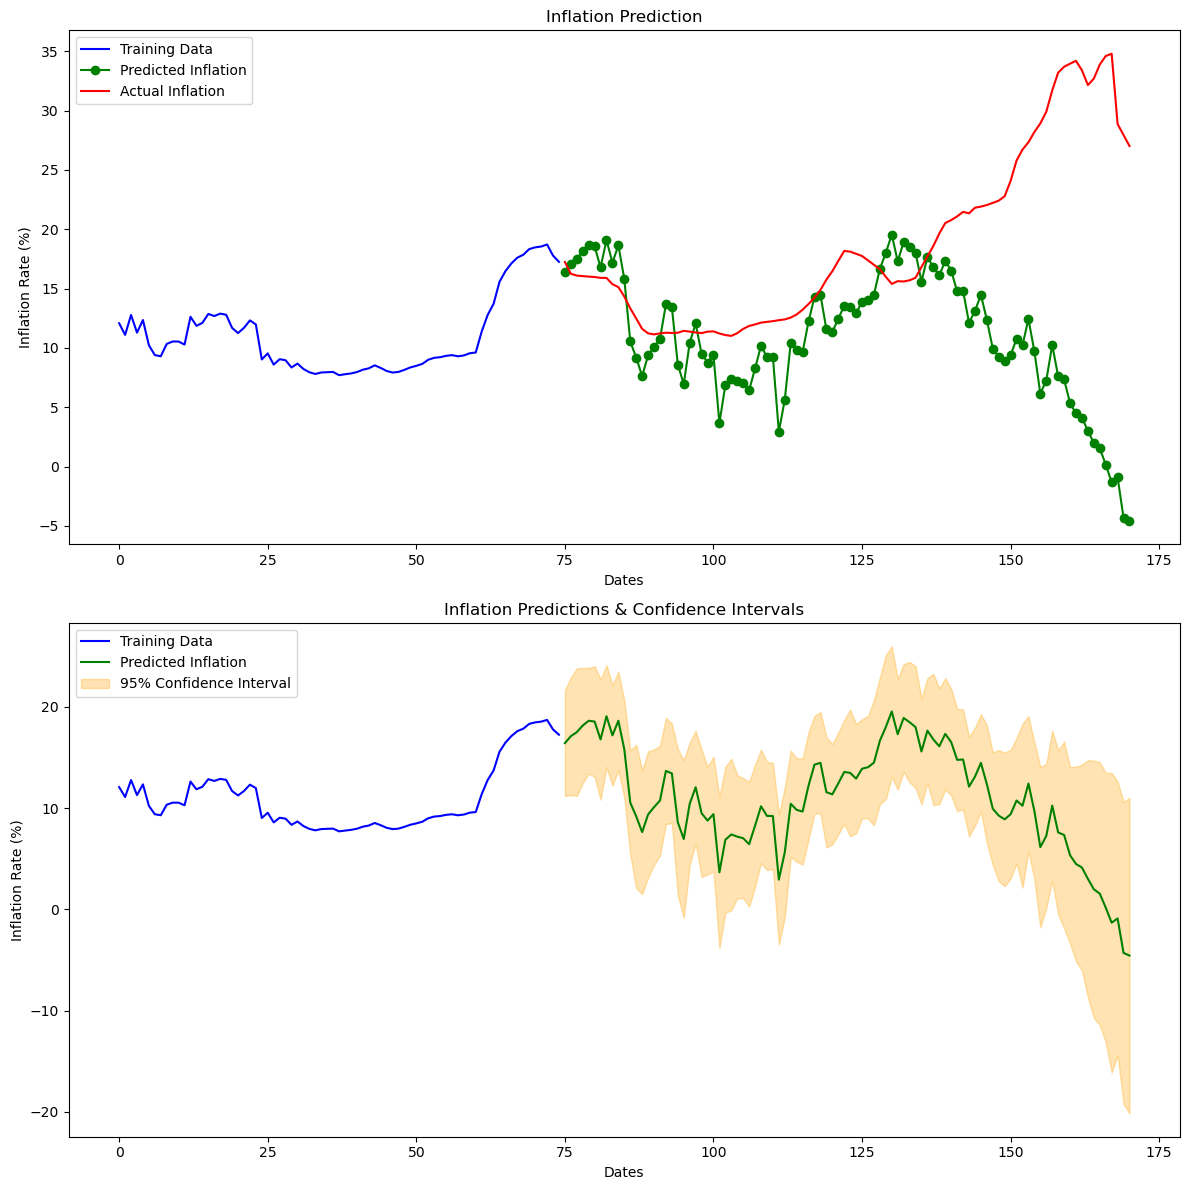

In [14]:
from scipy import stats

def get_linear_reg_confidence_intervals(model, X_train, X_test, y_train, confidence=0.95):
    # Convert DataFrames to numpy arrays for matrix operations
    X_train_array = X_train.values
    X_test_array = X_test.values
    y_train_array = y_train.values
    
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Calculate MSE and standard errors
    mse = np.sum((y_train_array - model.predict(X_train)) ** 2) / (len(X_train) - X_train.shape[1] - 1)
    
    # Calculate variance for predictions
    try:
        X_train_T_X_train = X_train_array.T.dot(X_train_array)
        X_train_T_X_train_inv = np.linalg.inv(X_train_T_X_train)
        X_test_var = np.diagonal(X_test_array.dot(X_train_T_X_train_inv).dot(X_test_array.T))
    except np.linalg.LinAlgError:
        # If matrix is singular, use pseudo-inverse
        X_train_T_X_train_inv = np.linalg.pinv(X_train_T_X_train)
        X_test_var = np.diagonal(X_test_array.dot(X_train_T_X_train_inv).dot(X_test_array.T))
    
    # Calculate standard error of predictions
    pred_std_error = np.sqrt(mse * (1 + X_test_var))
    
    # Get confidence intervals
    alpha = 1 - confidence
    degrees_of_freedom = len(X_train) - X_train.shape[1] - 1
    t_value = stats.t.ppf(1 - alpha/2, degrees_of_freedom)
    
    ci_lower = y_pred - t_value * pred_std_error
    ci_upper = y_pred + t_value * pred_std_error
    
    return ci_lower, ci_upper

# Calculate confidence intervals
ci_lower, ci_upper = get_linear_reg_confidence_intervals(gt_reg_model, X_train, X_test, y_train)

# Create visualization with confidence intervals
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Top subplot: Actual vs Predicted
axes[0].plot(train_data.index, y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, y_pred, color='green', marker='o',
             label='Predicted Inflation')
axes[0].plot(test_data.index, y_test, color='red', label='Actual Inflation')
axes[0].set_title('Inflation Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Inflation Rate (%)')
axes[0].legend()

# Bottom subplot: Predictions with Confidence Intervals
axes[1].plot(train_data.index, y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, y_pred, color='green', label='Predicted Inflation')
axes[1].fill_between(test_data.index, 
                    ci_lower, ci_upper,
                    alpha=0.3, color='orange',
                    label='95% Confidence Interval')
axes[1].set_title('Inflation Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Inflation Rate (%)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [15]:
# PERFORMANCE BEFORE REBASE (Jan 2024 - Dec 2024)
# first 12 months in the test set

# Get the first 12 months of the test set
metrics_gt_reg_df_before_rebase = calculate_metrics(y_test[:12], y_pred[:12])

# Create a DataFrame to store the metrics
metrics_gt_reg_df_before_rebase_df = pd.DataFrame({
    'Model': ['GT (Test Before Rebase)'],
    'R-squared': [metrics_gt_reg_df_before_rebase[0]],
    'MSE': [metrics_gt_reg_df_before_rebase[1]],
    'RMSE': [metrics_gt_reg_df_before_rebase[2]],
    'RMSPE': [metrics_gt_reg_df_before_rebase[3]],
    'MAE': [metrics_gt_reg_df_before_rebase[4]],
    'MAPE': [metrics_gt_reg_df_before_rebase[-2]],
    'SMAPE': [metrics_gt_reg_df_before_rebase[-1]]
})

# Print the metrics DataFrame
metrics_gt_reg_df_before_rebase_df = metrics_gt_reg_df_before_rebase_df.round(2)
display(metrics_gt_reg_df_before_rebase_df)

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,GT (Test Before Rebase),-4.23,4.82,2.2,14.38,2.01,13.03,12.46


In [16]:
# PERFORMANCE AFTER REBASE
# calculate the metrics for each model for y_test and y_pred last 3 months (Jan - Mar 2025)
metrics_gt_reg_df_after_rebase = calculate_metrics(y_test[-3:], y_pred[-3:])

# Create a DataFrame to store the metrics
metrics_gt_reg_df_after_rebase_df = pd.DataFrame({
    'Model': ['GT (Test After Rebase)'],
    'R-squared': [metrics_gt_reg_df_after_rebase[0]],
    'MSE': [metrics_gt_reg_df_after_rebase[1]],
    'RMSE': [metrics_gt_reg_df_after_rebase[2]],
    'RMSPE': [metrics_gt_reg_df_after_rebase[3]],
    'MAE': [metrics_gt_reg_df_after_rebase[4]],
    'MAPE': [metrics_gt_reg_df_after_rebase[-2]],
    'SMAPE': [metrics_gt_reg_df_after_rebase[-1]]
})

# Print the metrics DataFrame
metrics_gt_reg_df_after_rebase_df = metrics_gt_reg_df_after_rebase_df.round(2)
display(metrics_gt_reg_df_after_rebase_df)

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,GT (Test After Rebase),-1702.01,974.68,31.22,111.98,31.2,111.81,200.0


In [17]:
list_of_dfs = [
    metrics_gt_reg_df,
    metrics_gt_reg_df_before_rebase_df,
    metrics_gt_reg_df_after_rebase_df,
]

gt_result_df = pd.concat(list_of_dfs, axis=0)
gt_result_df

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,GT,-2.31,172.83,13.15,47.27,8.54,36.83,53.59
0,GT (Test Before Rebase),-4.23,4.82,2.20,14.38,2.01,13.03,12.46
0,GT (Test After Rebase),-1702.01,974.68,31.22,111.98,31.20,111.81,200.00


### Simple Linear Regression with GT only is poor overall implying a non-linear or autoregressive [or both] nature of the data.
<!-- It does perform better after the shock period compared to before the shock period indicating it might be useful for improving the autoregressive models tested before. -->

# ARIMA-X

In [18]:
ar_x = auto_arima(
                        y_train,
                        X=X_train,
                        # d=1, # from earlier pre-modelling analysis
                        d=2, # from the split sentivity analysis
                        seasonal=False, 
                        stepwise=True,
                        suppress_warnings=True, 
                        error_action="ignore", 
                        max_p=36,
                        max_order=None,
                        information_criterion='aic',
                        # information_criterion='bic',
                        # trace=True,
                        trace=False,
                        # box_cox=True, # for y only
                    )

print(f'(p, d, q): {ar_x.order}')

(p, d, q): (0, 2, 1)


In [19]:
model = ar_x  # seeded from the model we've already fit

def forecast_one_step(step):
    # Get the exogenous variables for the current step
    X_step = X_test.iloc[[step]]  # Use double brackets to keep DataFrame structure
    
    # Predict with exogenous variables
    fc, conf_int = model.predict(n_periods=1, X=X_step, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

# Enumerate through test set to keep track of index for X_test
for i, new_ob in enumerate(y_test):
    fc, conf = forecast_one_step(i)
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Update with both new observation and exogenous variables
    model.update(new_ob, X=X_test.iloc[[i]])


metrics_test_ar_x = calculate_metrics(y_test, forecasts)

# Create a DataFrame to store the metrics
metrics_test_ar_x_df = pd.DataFrame({
    'Model': ['AR-X'],
    'R-squared': [metrics_test_ar_x[0]],
    'MSE': [metrics_test_ar_x[1]],
    'RMSE': [metrics_test_ar_x[2]],
    'RMSPE': [metrics_test_ar_x[3]],
    'MAE': [metrics_test_ar_x[4]],
    'MAPE': [metrics_test_ar_x[-2]],
    'SMAPE': [metrics_test_ar_x[-1]]
})

# Print the metrics DataFrame
metrics_test_ar_x_df = metrics_test_ar_x_df.round(2)
display(metrics_test_ar_x_df)

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,AR-X,0.99,0.67,0.82,3.56,0.46,2.46,2.44


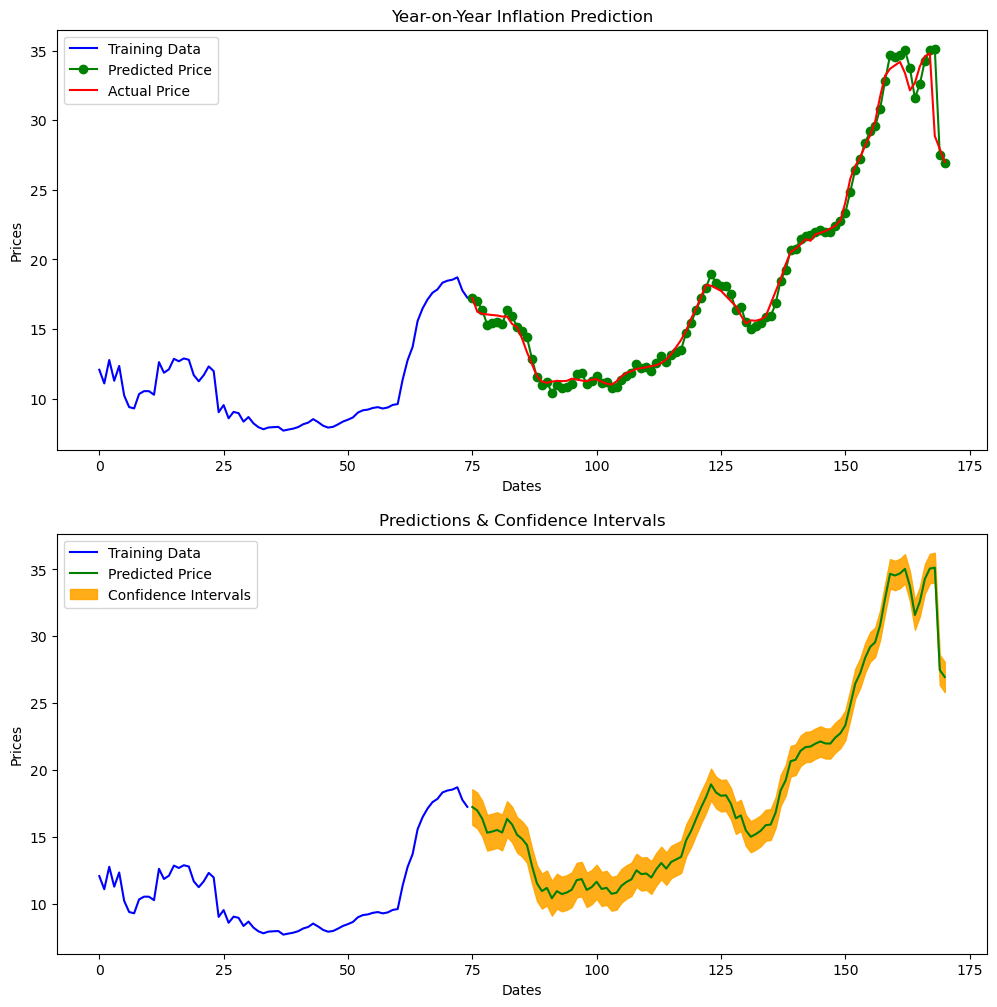

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('Year-on-Year Inflation Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

# axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

# axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].legend()

plt.savefig("ar_predictions.png")
plt.show()

In [21]:
# PERFORMANCE BEFORE REBASE (Jan 2024 - Dec 2024)
# first 12 months in the test set

# Get the first 12 months of the test set
metrics_test_ar_x_df_before_rebase = calculate_metrics(y_test[:12], forecasts[:12])

# Create a DataFrame to store the metrics
metrics_test_ar_x_df_before_rebase_df = pd.DataFrame({
    'Model': ['AR-X (Test Before Rebase)'],
    'R-squared': [metrics_test_ar_x_df_before_rebase[0]],
    'MSE': [metrics_test_ar_x_df_before_rebase[1]],
    'RMSE': [metrics_test_ar_x_df_before_rebase[2]],
    'RMSPE': [metrics_test_ar_x_df_before_rebase[3]],
    'MAE': [metrics_test_ar_x_df_before_rebase[4]],
    'MAPE': [metrics_test_ar_x_df_before_rebase[-2]],
    'SMAPE': [metrics_test_ar_x_df_before_rebase[-1]]
})

# Print the metrics DataFrame
metrics_test_ar_x_df_before_rebase_df = metrics_test_ar_x_df_before_rebase_df.round(2)
display(metrics_test_ar_x_df_before_rebase_df)

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,AR-X (Test Before Rebase),0.64,0.33,0.58,3.85,0.5,3.28,3.26


In [22]:
# PERFORMANCE AFTER REBASE
# calculate the metrics for each model for y_test and y_pred last 3 months (Jan - Mar 2025)

metrics_test_ar_x_df_after_rebase = calculate_metrics(y_test[-3:], forecasts[-3:])


# Create a DataFrame to store the metrics
metrics_test_ar_x_df_after_rebase_df = pd.DataFrame({
    'Model': ['AR-X (Test After Rebase)'],
    'R-squared': [metrics_test_ar_x_df_after_rebase[0]],
    'MSE': [metrics_test_ar_x_df_after_rebase[1]],
    'RMSE': [metrics_test_ar_x_df_after_rebase[2]],
    'RMSPE': [metrics_test_ar_x_df_after_rebase[3]],
    'MAE': [metrics_test_ar_x_df_after_rebase[4]],
    'MAPE': [metrics_test_ar_x_df_after_rebase[-2]],
    'SMAPE': [metrics_test_ar_x_df_after_rebase[-1]]
})

# Print the metrics DataFrame
metrics_test_ar_x_df_after_rebase_df = metrics_test_ar_x_df_after_rebase_df.round(2)
display(metrics_test_ar_x_df_after_rebase_df)

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,AR-X (Test After Rebase),-21.95,13.14,3.62,12.56,2.26,7.84,7.14


In [23]:
ar_x_list_of_dfs = [
    metrics_test_ar_x_df,
    metrics_test_ar_x_df_before_rebase_df,
    metrics_test_ar_x_df_after_rebase_df,
]

ar_x_result_df = pd.concat(ar_x_list_of_dfs, axis=0)
ar_x_result_df

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,AR-X,0.99,0.67,0.82,3.56,0.46,2.46,2.44
0,AR-X (Test Before Rebase),0.64,0.33,0.58,3.85,0.50,3.28,3.26
0,AR-X (Test After Rebase),-21.95,13.14,3.62,12.56,2.26,7.84,7.14


## Interpretability with SHAP

100%|██████████| 96/96 [02:28<00:00,  1.54s/it]


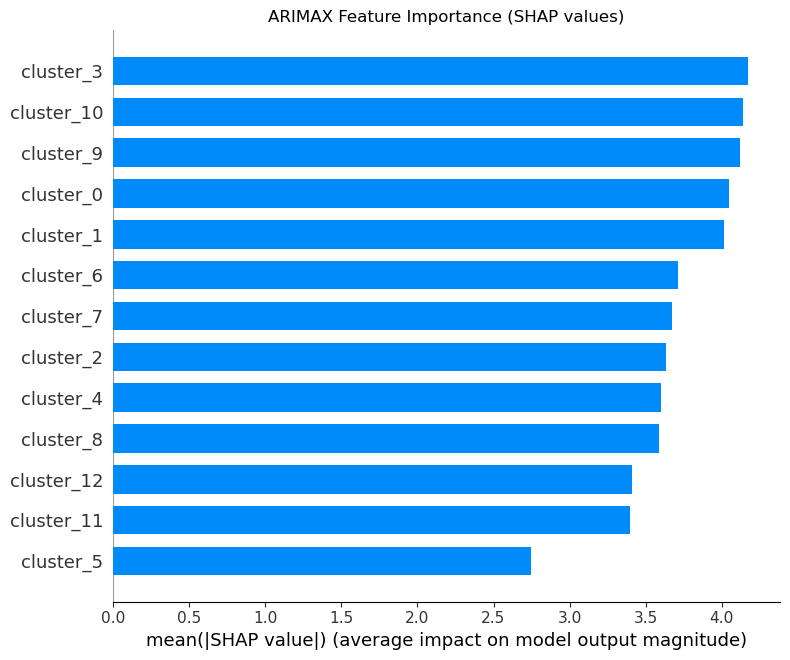

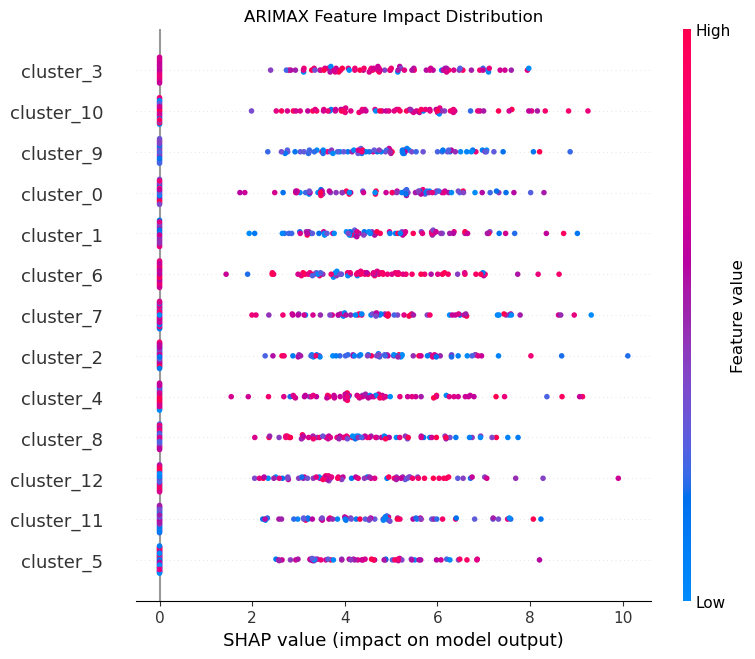


Feature Importance Rankings (SHAP):
       feature  importance  shap_values  relative_importance
3    cluster_3      4.1742       4.1742                 8.65
10  cluster_10      4.1427       4.1427                 8.58
9    cluster_9      4.1220       4.1220                 8.54
0    cluster_0      4.0453       4.0453                 8.38
1    cluster_1      4.0173       4.0173                 8.32
6    cluster_6      3.7131       3.7131                 7.69
7    cluster_7      3.6741       3.6741                 7.61
2    cluster_2      3.6330       3.6330                 7.53
4    cluster_4      3.5994       3.5994                 7.46
8    cluster_8      3.5858       3.5858                 7.43
12  cluster_12      3.4127       3.4127                 7.07
11  cluster_11      3.3960       3.3960                 7.04
5    cluster_5      2.7486       2.7486                 5.69


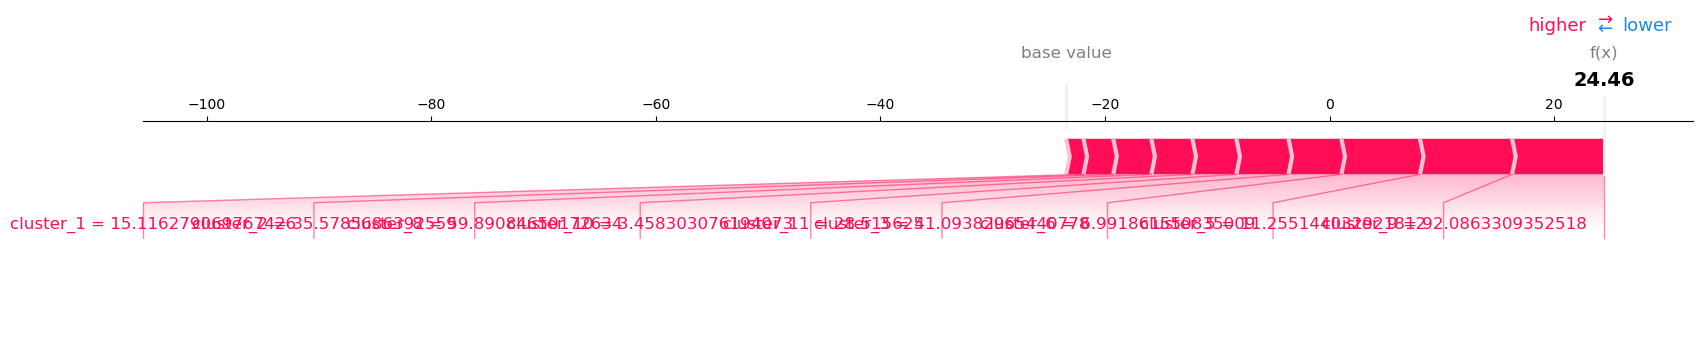

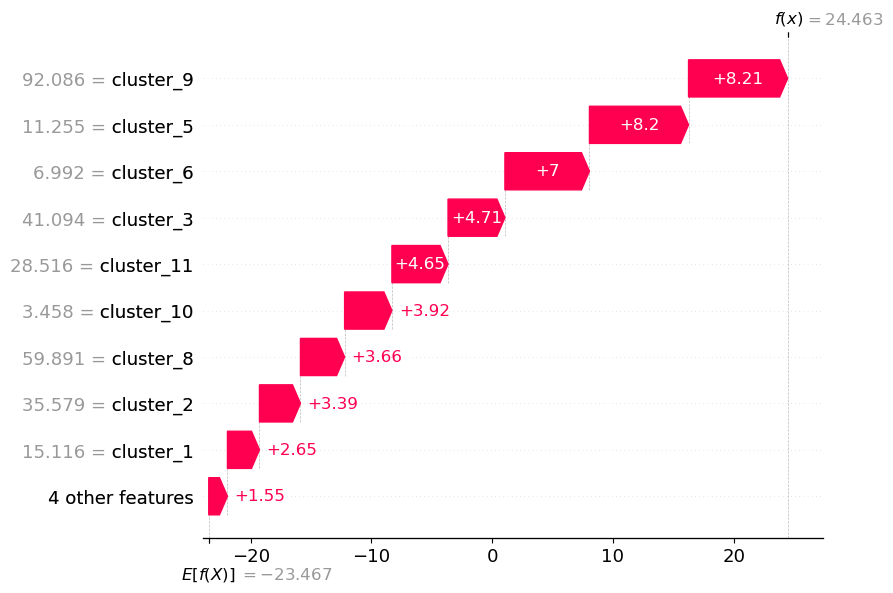

In [24]:
def analyze_arimax_importance_with_shap(ar_x_model, X_train, X_test):
    """
    Analyze feature importance of ARIMAX model using SHAP values
    """
    # Create a wrapper class for SHAP to work with ARIMAX
    class ArimaxWrapper:
        def __init__(self, model):
            self.model = model
        
        def predict(self, X):
            return self.model.predict(n_periods=X.shape[0], X=X)
    
    # Create wrapper instance
    model_wrapper = ArimaxWrapper(ar_x_model)
    
    # Calculate SHAP values
    explainer = shap.KernelExplainer(model_wrapper.predict, X_train)
    shap_values = explainer.shap_values(X_test)
    
    # Plot SHAP summary (bar plot)
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title("ARIMAX Feature Importance (SHAP values)")
    plt.tight_layout()
    plt.savefig("ar_importance.png")
    plt.show()
    
    # Plot detailed SHAP summary (beeswarm plot)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title("ARIMAX Feature Impact Distribution")
    plt.tight_layout()
    plt.savefig("ar_impact.png")
    plt.show()
    
    # Calculate feature importance metrics
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': np.abs(shap_values).mean(0),
        'shap_values': shap_values.mean(0)
    })
    
    # Calculate relative importance
    total_importance = feature_importance['importance'].sum()
    feature_importance['relative_importance'] = (feature_importance['importance'] / total_importance * 100).round(2)
    
    # Sort by absolute importance
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    # Print detailed feature importance
    print("\nFeature Importance Rankings (SHAP):")
    print(feature_importance.round(4))
    
    return feature_importance, shap_values, explainer

# Use the function
# importance_df, shap_vals, explainer = analyze_arimax_importance_with_shap(ar_x, X_train, X_test)
importance_df, shap_vals, explainer = analyze_arimax_importance_with_shap(model, X_train, X_test)

# Force plot
shap.initjs()  # Initialize JavaScript visualization
shap.force_plot(explainer.expected_value, 
                shap_vals[0,:], 
                X_test.iloc[0,:],
                matplotlib=True)

# Waterfall plot
shap.waterfall_plot(shap.Explanation(
    values=shap_vals[0,:],
    base_values=explainer.expected_value,
    data=X_test.iloc[0,:],
    feature_names=X_test.columns.tolist()
))

In [25]:
# X not normalized, d=1

# Model	                        R-squared	MSE	RMSE	RMSPE	MAE	MAPE	SMAPE
# 0	AR-X	                    0.99	0.67	0.82	3.51	0.47	2.47	2.46
# 0	AR-X (Test Before Rebase)	0.57	0.40	0.63	4.09	0.57	3.69	3.66
# 0	AR-X (Test After Rebase)	-20.94	12.56	3.54	12.30	2.50	8.77	8.14


In [26]:
# X not normalized, d=2

# Model	                        R-squared	MSE	RMSE	RMSPE	MAE	MAPE	SMAPE
# 0	AR-X	                    0.99	0.74	0.86	4.08	0.54	3.01	3.00
# 0	AR-X (Test Before Rebase)	0.23	0.71	0.84	5.45	0.77	4.99	4.99
# 0	AR-X (Test After Rebase)	-19.92	11.97	3.46	12.00	2.47	8.63	8.03


In [27]:
# X normalized, d=1

# Model	                        R-squared	MSE	RMSE	RMSPE	MAE	MAPE	SMAPE
# 0	AR-X	                    0.99	0.67	0.82	3.52	0.47	2.48	2.47
# 0	AR-X (Test Before Rebase)	0.58	0.39	0.62	4.05	0.57	3.67	3.63
# 0	AR-X (Test After Rebase)	-21.18	12.69	3.56	12.37	2.56	8.99	8.37


In [28]:
# X normalized, d=2

# Model	                        R-squared	MSE	RMSE	RMSPE	MAE	MAPE	SMAPE
# 0	AR-X	                    0.99	0.67	0.82	3.56	0.46	2.46	2.44
# 0	AR-X (Test Before Rebase)	0.64	0.33	0.58	3.85	0.50	3.28	3.26
# 0	AR-X (Test After Rebase)	-21.95	13.14	3.62	12.56	2.26	7.84	7.14
